# Analyse de l'influence des distributions des temps inter-véhiculaires sur un axe routier

Paramètres de simulation:
- 1 voie
- longueur de la voie : 15900 m
- présence d'outils de contrôle de la circulation : non
- paramètres de distribution 
    <br/> dn -> N(8.33, 1) [m]
    <br/> longueur -> N(7, 1) [m]
    <br/> vitesse -> N(14, 3) [m.s^-1]
    <br/> t -> N(2, 0.5) [s]
- durée de la simulation : 500 s = 5000 1/10s   
- seed pour reproductibilité : 45

import des librairies:

In [1]:
import numpy as np  
import network, simulation, toolkit
import makesimulation 
import matplotlib.pyplot as plt
import analysis
import statistics
import seaborn
from trafficintelligence import events, moving

OpenCV library could not be loaded (video replay functions will not be available)
OpenCV library could not be loaded (video replay functions will not be available)


Récupération des fichiers initiaux

In [2]:
world = network.World.load('simple-net.yml')  
sim = simulation.Simulation.load('config.yml')

- headways -> Exp(1.8, 1)
</br> On décalle la distribution à 1s % les temps inter-véhiculaires produits ne seront pas inférieurs à cette valeur

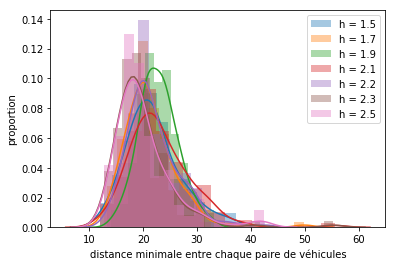

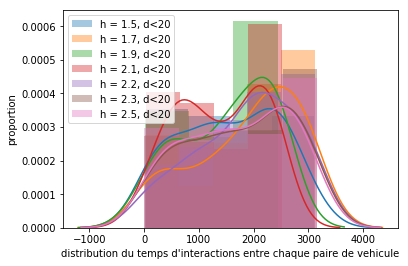

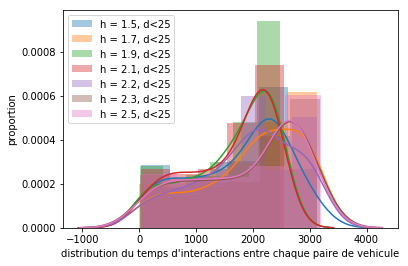

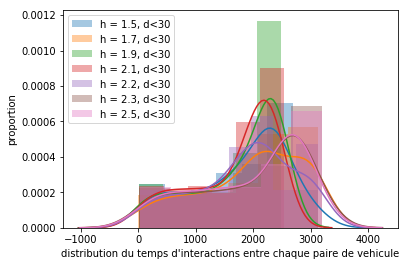

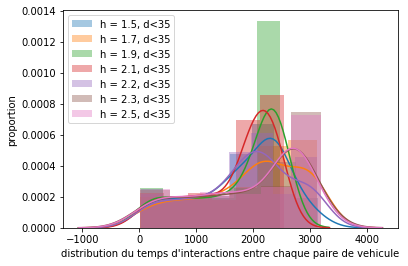

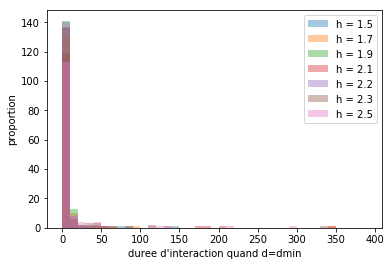

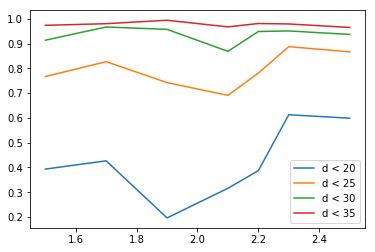

In [4]:
# liste des seeds a tester
seeds = [45]#,46]#,47,48,49,50]


for seed in seeds:
    sim.seed = seed

    # liste des headways a essayer:
    headways = [1.5, 1.7, 1.9, 2.1, 2.2, 2.3, 2.5]#, 1.6, 1.8, 2, 2.2]#, 2.4, 2.6, 2.8]
    cList = []
    fig0 = plt.figure(num=0)
    cList = {}
    durationList = {}
    durationList2 = {}
    count = {}
    
    for h in headways:
        # modification des paramètres dans simple-net.yml
        world = network.World.load('simple-net.yml')  
        world.userInputs[0].distributions['headway'].scale = h-world.userInputs[0].distributions['headway'].loc

        # running the simulation
        world = makesimulation.run(world, sim)
        
        # distribution des distances minimales d'interaction
        interactions = []
        # 1ere etape : recuperer la liste des interactions entre chaque paire de vehicules
        for k in range(len(world.userInputs[0].alignment.users)-1):
            roadUser1 = world.userInputs[0].alignment.users[k]
            roadUser2 = world.userInputs[0].alignment.users[k+1]
            if roadUser1.timeInterval is not None and roadUser2.timeInterval is not None:
                i = events.Interaction(useCurvilinear=True, roadUser1=roadUser1, roadUser2=roadUser2)
                i.computeIndicators(world=world, alignment1=world.travelledAlignments(roadUser1), alignment2=world.travelledAlignments(roadUser2)) 
                interactions.append(i)
        
        # recupérer la valeur minimale des distances entre chaque paire de vehicule 
        minDistances = [min(i.indicators['Distance'].values.values()) for i in interactions]
        plt.figure(num=0)
        ax = seaborn.distplot(minDistances, rug=False, hist=True, label='h = '+str(h), norm_hist=True)
        # pour chaque tiv testé on obtient la distribution des distances minimales entre chaque paire de véhicules
        plt.xlabel("distance minimale entre chaque paire de véhicules")
        plt.ylabel("proportion")
        ax.legend()
               
        minDistances = [20,25,30,35]
        cList[h] = {}
        
        for distance in minDistances:
            duration = []
            # rapport durée interaction
            for i in interactions:
                interactionLength = []
                for t in list(i.timeInterval):
                    if i.indicators['Distance'].values[t] < distance:
                        interactionLength.append(1)
                    else:
                        interactionLength.append(0)
                interactionDuration = sum(toolkit.makeSubListFromList(interactionLength, 1))
    #             interactionDuration = interactionDuration / len(list(i.timeInterval))
                duration.append(interactionDuration)
            durationList[h] = list(filter(lambda v: v !=0, duration))
            plt.figure(num=distance)
            ax=seaborn.distplot(durationList[h], rug=False, hist=True, label='h = '+str(h)+', d<'+str(distance), norm_hist=False)
            plt.xlabel("distribution du temps d'interactions entre chaque paire de vehicule")
            plt.ylabel("proportion")
            ax.legend()
            
        
        durationList2[h] = []
        # #############################################################333
        for i in interactions:
            duration2 = []
            interactionLength2 = []

            for t in list(i.timeInterval):

                if i.indicators['Distance'].values[t] == min(i.indicators['Distance'].values.values()):
                    interactionLength2.append(1)
                else:
                    interactionLength2.append(0)
        #     print(interactionLength2)
            interactionDuration2 = sum(toolkit.makeSubListFromList(interactionLength2, 1))
            durationList2[h].append(interactionDuration2)
        # ax=seaborn.distplot(durationList2[1.7], rug=False, hist=True, label='h = '+str(1.7), norm_hist=False)
        plt.figure('distance min')
        plt.hist(durationList2[h], label='h = '+str(h), density=False, bins=[k for k in range(0,400,10)], alpha=.4)
        plt.xlabel("duree d'interaction quand d=dmin")
        plt.ylabel("proportion")
        plt.legend()
        
        count[h] = {}
        for distance in minDistances:
            count[h][distance] = 0
            for i in interactions:
                interactionLength = []
                for t in list(i.timeInterval):
                    if i.indicators['Distance'].values[t] < distance:
                        interactionLength.append(1)
                    else:
                        interactionLength.append(0)
                count[h][distance] += toolkit.countElementInList(interactionLength, 1)
            count[h][distance] /= len(world.getNotNoneVehiclesInWorld()[0])
                
    count = toolkit.inverseDict(count, headways, minDistances)
    plt.figure('compte')
    for el in count:
        plt.plot(list(count[el].keys()), list(count[el].values()), label='d < '+str(el))
        plt.legend()
    

toolkit.callMeWhenTestAreDone()

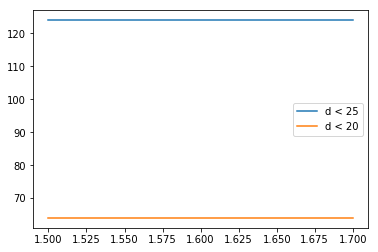

In [64]:
# recupération du nombre d'interactions/nombre de véhicules générés survenant 
# à moins de 20/25/30 m pour chaque headway testé
import importlib
import toolkit
importlib.reload(toolkit)
count = {}
for h in headways : 
    count[h] = {}
    for distance in minDistances:
        count[h][distance] = 0
        for i in interactions:
            interactionLength = []
            for t in list(i.timeInterval):
                if i.indicators['Distance'].values[t] < distance:
                    interactionLength.append(1)
                else:
                    interactionLength.append(0)
            count[h][distance] += toolkit.countElementInList(interactionLength, 1)
count = toolkit.inverseDict(count, headways, minDistances)
plt.figure('compte')
for el in count:
    plt.plot(list(count[el].keys()), list(count[el].values()), label='d < '+str(el))
    plt.legend()
    

trying headway = 0.5
115 248925
trying headway = 0.6
113 240153
trying headway = 0.7
124 302476
trying headway = 0.7999999999999999
123 289432
trying headway = 0.8999999999999999
121 280636
trying headway = 0.9999999999999999
131 307239
trying headway = 1.0999999999999999
105 217033
trying headway = 1.1999999999999997
121 281906
trying headway = 1.2999999999999998
126 283420
trying headway = 1.4
103 204036
trying headway = 1.4999999999999998
123 272086
trying headway = 1.5999999999999996
112 246593
trying headway = 1.6999999999999997
121 262874
trying headway = 1.7999999999999998
110 238880
trying headway = 1.8999999999999997
120 255540
trying headway = 1.9999999999999996
95 173925


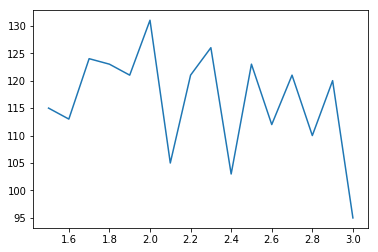

In [5]:
sim.seed = 45

# liste des headways a essayer:
headways = [x for x in np.arange(.5,2.1,.1)]
# headways = [.8, .9, ]
hList = []
cList = []
for h in headways:
    # modification des paramètres dans simple-net.yml
    # au cas ou
    world = network.World.load('simple-net.yml')  
    
    world.userInputs[0].distributions['headway'].scale = h

    # running the simulation
    world = makesimulation.run(world, sim)
    print('trying headway = {}'.format(h))
    
    #get number of interactions
    interactionDuration = world.getInteractionsDuration(dmin=25, inLine=True)
    c = 0 # nombre d'interaction
    s = 0 # duree moyenne des interactions
    interactionLength = []
    for pair in interactionDuration:
        if interactionDuration[pair][0] !=0:
            c += interactionDuration[pair][0]
            s += sum(interactionDuration[pair][1:])
            interactionLength.append(interactionDuration[pair][1:])
    print(c, s)
    hList.append(1+h)
    cList.append(c)
plt.plot(hList, cList)
plt.show()

<br/> Nombre de véhicules simulés/Nombre de véhicules générés : 

print(str(len(world.getNotNoneVehiclesInWorld()[0])) + '/'+ str(len(world.users)))

Distribution des headways observés

h = analysis.getHeadwayValues(world)
plt.xlabel('headway values')
plt.ylabel('Proportions')
plt.hist(h[0], density=True, bins = 25)

# print(statistics.mean(h[0]))
# print(statistics.mean(world.userInputs[0].headways))

Distribution des min des distances inter-véhiculaires, pour une coexistence d'une durée minimale de 2 min = 1200 1/10s

d = analysis.getMinDistanceBetweenEachPairCF(world, 1200)

plt.hist(d, bins=22, density=False)# 'min distance between users', 'proportions')

Nombre d'interactions et leur durée observées à une distance < 25 m

In [36]:
interactionDuration = world.getInteractionsDuration(dmin=25, inLine=True)

c = 0 # nombre d'interaction
s = 0 # duree moyenne des interactions
interactionLength = []
for pair in interactionDuration:
    if interactionDuration[pair][0] !=0:
        c += interDuration[pair][0]
        s += sum(interactionDuration[pair][1:])
        interactionLength.append(interactionDuration[pair][1:])
print(c, s)

Durée moyenne des interactions

if c != 0:
    print(s/c)

distribution de la durée des interactions (ayant lieu a une distance < 25 m)
</br>**a voir**

plt.hist(interactionLength, bins=3, density=False)

Tracé des courbes de TTC

minTTCValues = analysis.getTTCValuesForEachPairOfVehicles(world, sim, plot=True)[1]

Distribution des TTC min

plt.hist(minTTCValues, bins=30, density=True)
minTTCValues

- headways -> Exp(2, 1)